In [39]:
import torch
import torchvision
import h5py
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold

TRAIN = "/home/zhaoxun/codes/Panda/_data/iafoss/train"
LABELS = '/home/zhaoxun/codes/Panda/_data/train.csv'


class PngData(object):
    def __init__(self, TRAIN, LABELS, N, size, batchsize):
        self.TRAIN = TRAIN
        self.mean = torch.tensor([1.0 - 0.90949707, 1.0 - 0.8188697, 1.0 - 0.87795304])[..., None, None]
        self.std = torch.tensor([0.36357649, 0.49984502, 0.40477625])[..., None, None]
        self.sz = size
        self.N = N

        nfolds = 5
        df = pd.read_csv(LABELS).set_index('image_id')
        files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
        df = df.loc[files]
        df = df.reset_index()
        splits = StratifiedKFold(n_splits = nfolds, random_state =1, shuffle =True)
        splits = list(splits.split(df, df.isup_grade))
        folds_splits = np.zeros(len(df)).astype(np.int)
        for i in range(nfolds):
            folds_splits[splits[i][1]] = i
        df['split'] = folds_splits
        self.df = df

    @classmethod
    def open_image(cls, fn, div = True, convert_mode = 'RGB', imcls = Image, after_open = None):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            x = PIL.Image.open(fn).convert(convert_mode)
        if after_open:
            x = after_open(x)
        x = pil2tensor(x, np.float32)
        if div: x.div_(255)
        return imcls(1.0 - x)

    @property
    def MyImage(self):
        outter = self
        class _MyImage(ItemBase):
            def __init__(self, imgs):
                self.obj = (imgs)
                self.data = [(img.data - outter.mean) / outter.std for img in imgs]

            def __repr__(self): 
                return f'{self.__class__.__name__} {[img.shape for img in self.obj]}'

            def apply_tfms(self, tfms, *args, **kwargs):
                for i in range(len(self.obj)):
                    self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
                    self.data[i] = (self.obj[i].data - outter.mean) / outter.std
                return self

            def to_one(self):
                img = torch.stack(self.data, 1)
                img = (img
                    .view(3, -1, outter.N, outter.sz, outter.sz)
                    .permute(0, 1, 3, 2, 4)
                    .contiguous()
                    .view(3, -1, outter.sz, outter.N))
                return Image(1.0 - (outter.mean + img * outter.std))
        return _MyImage

    @property
    def MyImageItemList(self):
        outter = self
        class _MyImageItemList(ImageList):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)

            def __len__(self): 
                return len(self.items) or 1

            def get(self, i):
                fn = Path(self.items[i])
                fnames = [Path("%s_%d.png" % (fn, i)) for i in range(outter.N)]
                imgs = [outter.open_image(fname, convert_mode = self.convert_mode, after_open = self.after_open) for fname in fnames]
                return outter.MyImage(imgs)

            def reconstruct(self, t):
                return outter.MyImage([outter.mean + ti * outter.std for ti in t])

            def show_xys(self, xs, ys, figsize = (300, 50), **kwargs):
                rows = min(len(xs), 8)
                fig, axs = plt.subplots(rows, 1, figsize = figsize)
                for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
                    xs[i].to_one().show(ax = ax, y = ys[i], **kwargs)
                plt.tight_layout()
        return _MyImageItemList

    # collate function to combine multiple images into one tensor
    def MImage_collate(self, batch) -> Tensor:
        result = torch.utils.data.dataloader.default_collate(to_data(batch))
        if isinstance(result[0], list):
            result = [torch.stack(result[0], 1), result[1]]
        return result

    def get_data(self, bs, bg = None, br = 0.8):
        trainidx = self.df.index[self.df.split != 0].tolist()
        if bg is not None: trainidx = np.random.choice(trainidx, round(len(trainidx) * br), replace = False)
        validx = self.df.index[self.df.split == 0].tolist()
        return (self.MyImageItemList.from_df(self.df, path = '/', folder = self.TRAIN, cols = 'image_id')
                .split_by_idxs(trainidx, validx)
                .label_from_df(cols = ['isup_grade'])
                .transform(get_transforms(flip_vert = True, max_rotate = 15), size = self.sz, padding_mode = 'zeros')
                .databunch(bs = bs, num_workers = 4))


In [40]:
md = PngData(TRAIN, LABELS, 16, 128, 16)
data = md.get_data(16, 0, 0.8)
for x, y in data.train_dl:
    break

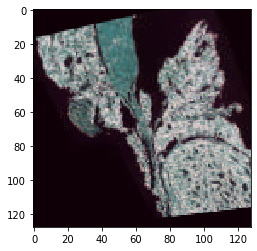

In [32]:
norm = lambda x: (((x - np.min(x)) / np.ptp(x)) * 255).astype(np.int)
xi = x[0][0].cpu().data.numpy().transpose((1, 2, 0))
plt.imshow(norm(xi))

In [41]:
print(data.train_ds.__len__())
print(data.valid_ds.__len__())

6730
2104


In [65]:
df = pd.read_csv(LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
df = df.loc[files]
df = df.reset_index()
splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds): 
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df = df.iloc[4696:4700,:]
data = get_data()

/data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [66]:
for X, y in data.train_dl:
    break
print(len(X))
X[0].shape

16


torch.Size([2, 3, 128, 128])

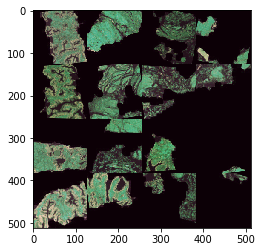

In [11]:
ml = MImageItemList.from_df(df, path='/', folder=TRAIN, cols='image_id')
his = np.stack([x[0].cpu().data.numpy().transpose(1, 2, 0) for x in X])
his = np.concatenate([np.concatenate([his[i * 4 + j] for j in range(4)], axis = 0) for i in range(4)], axis = 1)
plt.imshow(norm(his))

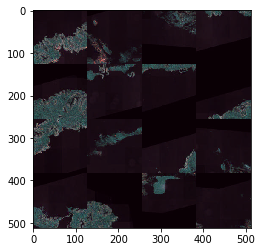

In [6]:
ml = MImageItemList.from_df(df, path='/', folder=TRAIN, cols='image_id')
his = np.stack([(x.data.numpy() * 255).astype(np.int).transpose(1, 2, 0) for x in ml.get(0).data])
his = np.concatenate([np.concatenate([his[i * 4 + j] for j in range(4)], axis = 0) for i in range(4)], axis = 1)
norm = lambda x: (((x - np.min(x)) / np.ptp(x)) * 255).astype(np.int)
plt.imshow(norm(his))

In [64]:
from fastai import *
from fastai.vision import *
import warnings
from sklearn.model_selection import StratifiedKFold
TRAIN = "/home/zhaoxun/codes/Panda/_data/iafoss/train"
LABELS = '/home/zhaoxun/codes/Panda/_data/train.csv'
nfolds = 5
SEED = 0
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])
df = pd.read_csv(LABELS).set_index('image_id')
sz = 128
bs = 2
N = 16
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
    after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(1.0-x) #invert image for zero padding

class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj, self.data = \
        (imgs), [(imgs[i].data - mean[...,None,None])/std[...,None,None] for i in range(len(imgs))]
    
    def apply_tfms(self, tfms,*args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean[...,None,None])/std[...,None,None]
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {img.shape for img in self.obj}'

    def to_one(self):
        img = torch.stack(self.data,1)
        img = img.view(3,-1,N,sz,sz).permute(0,1,3,2,4).contiguous().view(3,-1,sz*N)
        return Image(1.0 - (mean[...,None,None]+img*std[...,None,None]))

class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn)+'_'+str(i)+'.png')for i in range(N)]
        imgs = [open_image(fname, convert_mode=self.convert_mode, after_open=self.after_open)
            for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean[...,None,None]+_t*std[...,None,None] for _t in t])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(300,50), **kwargs):
        rows = min(len(xs),8)
        fig, axs = plt.subplots(rows,1,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

#collate function to combine multiple images into one tensor
def MImage_collate(batch:ItemsList)->Tensor:
    result = torch.utils.data.dataloader.default_collate(to_data(batch))
    if isinstance(result[0],list):
        result = [torch.stack(result[0],1),result[1]]
    return result

def get_data(fold=0):
    return (MImageItemList.from_df(df, path='/', folder=TRAIN, cols='image_id')
    .split_by_idx(df.index[df.split == fold].tolist())
    .label_from_df(cols=['isup_grade'])
    .transform(get_transforms(flip_vert=True,max_rotate=15),size=sz,padding_mode='zeros')
    .databunch(bs=bs,num_workers=4))